In [ ]:
!pip install spotipy


     |████████████████████████████████| 63 kB 1.4 MB/s 
     |████████████████████████████████| 138 kB 20.7 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

from collections import defaultdict
from sklearn.metrics import euclidean_distances
from scipy.spatial.distance import cdist
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

import difflib

import numpy as np, pandas as pd,  os, pickle

import seaborn as sns
import plotly.express as px 
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import requests
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import euclidean_distances
from sklearn.manifold import TSNE

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from scipy.spatial.distance import cdist

import tensorflow as tf
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Flatten


import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving data.csv to data.csv


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving spotify_data.csv to spotify_data.csv


In [ ]:
data1 = pd.read_csv("data.csv")
data2 = pd.read_csv("spotify_data.csv")

In [ ]:
#Ziv
dump_file_name = '/content/drive/MyDrive/dump_data.pickle'

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Saving the data

In [ ]:
with open(dump_file_name, 'w+b') as out_file: 
    pickle.dump(data1, out_file, pickle.HIGHEST_PROTOCOL)
    pickle.dump(data2, out_file, pickle.HIGHEST_PROTOCOL)

Loadind the pickle file

In [ ]:
with open(dump_file_name,'rb') as in_file:
    data1 = pickle.load(in_file)
    data2 = pickle.load(in_file)

In [ ]:
data2 = data2.rename(columns = {"track_id" : "id"})

In [ ]:
data2 = data2.drop("time_signature", inplace = False, axis = 1)
data2

,genre,artist_name,track_name,id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence
0,Movie,Henri Salvador,C'est beau de faire un Show,0BRjO6ga9RKCKjfDqeFgWV,0,0.61100,0.389,99373,0.910,0.000000,C#,0.3460,-1.828,Major,0.0525,166.969,0.814
1,Movie,Martin & les fées,Perdu d'avance (par Gad Elmaleh),0BjC1NfoEOOusryehmNudP,1,0.24600,0.590,137373,0.737,0.000000,F#,0.1510,-5.559,Minor,0.0868,174.003,0.816
2,Movie,Joseph Williams,Don't Let Me Be Lonely Tonight,0CoSDzoNIKCRs124s9uTVy,3,0.95200,0.663,170267,0.131,0.000000,C,0.1030,-13.879,Minor,0.0362,99.488,0.368
3,Movie,Henri Salvador,Dis-moi Monsieur Gordon Cooper,0Gc6TVm52BwZD07Ki6tIvf,0,0.70300,0.240,152427,0.326,0.000000,C#,0.0985,-12.178,Major,0.0395,171.758,0.227
4,Movie,Fabien Nataf,Ouverture,0IuslXpMROHdEPvSl1fTQK,4,0.95000,0.331,82625,0.225,0.123000,F,0.2020,-21.150,Major,0.0456,140.576,0.390
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232720,Soul,Slave,Son Of Slide,2XGLdVl7lGeq8ksM6Al7jT,39,0.00384,0.687,326240,0.714,0.544000,D,0.0845,-10.626,Major,0.0316,115.542,0.962
232721,Soul,Jr Thomas & The Volcanos,Burning Fire,1qWZdkBl4UVPj9lK6HuuFM,38,0.03290,0.785,282447,0.683,0.000880,E,0.2370,-6.944,Minor,0.0337,113.830,0.969
232722,Soul,Muddy Waters,(I'm Your) Hoochie Coochie Man,2ziWXUmQLrXTiYjCg2fZ2t,47,0.90100,0.517,166960,0.419,0.000000,D,0.0945,-8.282,Major,0.1480,84.135,0.813
232723,Soul,R.LUM.R,With My Words,6EFsue2YbIG4Qkq8Zr9Rir,44,0.26200,0.745,222442,0.704,0.000000,A,0.3330,-7.137,Major,0.1460,100.031,0.489


###Wedding playlist planner

First, We'll look again at the way the data is built

In [ ]:
data.head()

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo
0,0.0594,1921,0.982,"['Sergei Rachmaninoff', 'James Levine', 'Berli...",0.279,831667,0.211,0,4BJqT0PrAfrxzMOxytFOIz,0.878000,10,0.665,-20.096,1,"Piano Concerto No. 3 in D Minor, Op. 30: III. ...",4,1921,0.0366,80.954
1,0.9630,1921,0.732,['Dennis Day'],0.819,180533,0.341,0,7xPhfUan2yNtyFG0cUWkt8,0.000000,7,0.160,-12.441,1,Clancy Lowered the Boom,5,1921,0.4150,60.936
2,0.0394,1921,0.961,['KHP Kridhamardawa Karaton Ngayogyakarta Hadi...,0.328,500062,0.166,0,1o6I8BglA6ylDMrIELygv1,0.913000,3,0.101,-14.850,1,Gati Bali,5,1921,0.0339,110.339
3,0.1650,1921,0.967,['Frank Parker'],0.275,210000,0.309,0,3ftBPsC5vPBKxYSee08FDH,0.000028,5,0.381,-9.316,1,Danny Boy,3,1921,0.0354,100.109
4,0.2530,1921,0.957,['Phil Regan'],0.418,166693,0.193,0,4d6HGyGT8e121BsdKmw9v6,0.000002,3,0.229,-10.096,1,When Irish Eyes Are Smiling,2,1921,0.0380,101.665


We want to create a function that will recive a playlist and first of all will come up with the "closest" songs to it. This will be implemnted by using cosine similarity based on all the parameters the songs have. Because our database is limited, We've opened a developer account to spotify and got access to their API

In [ ]:
sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id="580f672dd30c465db2bf0be7799c9e52", client_secret="91970e0ef1244c2aa0e0da821befaff4"))



Then we develop a brach of functions calling one another. The first clusters the songs by k-means. This will be used to assign a genere to a song as another properity. The second finds a song data by name and year. the third extracts the song data (the different parameters) from spotify API into a vector. The fourth converts a list of songs data into a normalized vector by a mean. The fifth converts songs into flatten dicts.

So the final "product" function is the recommended songs function. It recives a list of songs and years, a target age audienece and the minimum length of the playlist. The function takes the list and orders all the first 1000 songs most similar by cosine similarity to the list in spotify API, than filters out songs by their year according to the range around the target audeince. The output is the first n songs from the ordered list that reach the minimum length deffined in hours.

In [1]:
song_cluster_pipeline = Pipeline([('scaler', StandardScaler()), 
                                  ('kmeans', KMeans(n_clusters=20, 
                                   verbose=False, n_jobs=4))
                                 ], verbose=False)

X = data.select_dtypes(np.number)
number_cols = list(X.columns)
song_cluster_pipeline.fit(X)
song_cluster_labels = song_cluster_pipeline.predict(X)
data['cluster_label'] = song_cluster_labels

NameError: ignored

In [ ]:
def find_song(name, year):
    song_data = defaultdict()
    results = sp.search(q= 'track: {} year: {}'.format(name,year), limit=1)
    if results['tracks']['items'] == []:
        return None

    results = results['tracks']['items'][0]
    track_id = results['id']
    audio_features = sp.audio_features(track_id)[0]

    song_data['name'] = [name]
    song_data['year'] = [year]
    song_data['explicit'] = [int(results['explicit'])]
    song_data['duration_ms'] = [results['duration_ms']]
    song_data['popularity'] = [results['popularity']]

    for key, value in audio_features.items():
        song_data[key] = value


In [ ]:
from collections import defaultdict
from sklearn.metrics import euclidean_distances
from scipy.spatial.distance import cdist
import difflib

number_cols = ['valence', 'year', 'acousticness', 'danceability', 'duration_ms', 'energy', 'explicit',
 'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 'popularity', 'speechiness', 'tempo']


def get_song_data(song, spotify_data):
    
    try:
        song_data = spotify_data[(spotify_data['name'] == song['name']) 
                                & (spotify_data['year'] == song['year'])].iloc[0]
        return song_data
    
    except IndexError:
        return find_song(song['name'], song['year'])
        

def get_mean_vector(song_list, spotify_data):
    
    song_vectors = []
    
    for song in song_list:
        song_data = get_song_data(song, spotify_data)
        if song_data is None:
            print('Warning: {} does not exist in Spotify or in database'.format(song['name']))
            continue
        song_vector = song_data[number_cols].values
        song_vectors.append(song_vector)  
    
    song_matrix = np.array(list(song_vectors))
    return np.mean(song_matrix, axis=0)


def flatten_dict_list(dict_list):
    
    flattened_dict = defaultdict()
    for key in dict_list[0].keys():
        flattened_dict[key] = []
    
    for dictionary in dict_list:
        for key, value in dictionary.items():
            flattened_dict[key].append(value)
            
    return flattened_dict


def recommend_songs( song_list, spotify_data,hours,age,n_songs=10):
    
    metadata_cols = ['name', 'year', 'artists']
    song_dict = flatten_dict_list(song_list)
    
    song_center = get_mean_vector(song_list, spotify_data)
    scaler = song_cluster_pipeline.steps[0][1]
    scaled_data = scaler.transform(spotify_data[number_cols])
    scaled_song_center = scaler.transform(song_center.reshape(1, -1))
    distances = cdist(scaled_song_center, scaled_data, 'cosine')
    index = list(np.argsort(distances)[:, :1000][0])
    index=[i for i in index if (spotify_data.iloc[i]['year']>(2022-age+18) and spotify_data.iloc[i]['year']<(2022-age+30))]
    rec_songs = spotify_data.iloc[index[0:n_songs]]
    while sum(rec_songs['duration_ms'])<(hours*3.6e+6):
      n_songs+=1
      rec_songs = spotify_data.iloc[index[0:n_songs]]
    print('playlist length is :{} hours'.format(sum(rec_songs['duration_ms'])/3.6e+6))
    rec_songs = rec_songs[~rec_songs['name'].isin(song_dict['name'])]
    return rec_songs[metadata_cols].to_dict(orient='records')

This is an example from my actual weeding playlist! (Itamar)

In [ ]:
recommend_songs([{'name': 'Shut Up and Dance', 'year':2014},
                {'name': 'I Gotta Feeling', 'year': 2009},
                {'name': 'The Nights', 'year': 2014},
                {'name': 'Diamonds', 'year': 2012},
                {'name': 'A Sky Full of Stars', 'year': 2014}],data,2,28)

[[-0.15574383  1.38178362 -1.27236649  0.30660451  0.00498493  1.07609427
  -0.30395549 -0.53151365 -0.11375096  0.3475967   1.06947507  0.20452811
   2.04192615 -0.35180905  0.09518589]]
playlist length is :2.0262580555555556 hours


[{'artists': "['Carly Rae Jepsen']",
  'name': 'I Really Like You',
  'year': 2015},
 {'artists': "['Luke Combs']", 'name': 'When It Rains It Pours', 'year': 2017},
 {'artists': "['Cody Simpson']", 'name': 'La Da Dee', 'year': 2019},
 {'artists': "['COIN']", 'name': 'Talk Too Much', 'year': 2017},
 {'artists': "['Luke Combs']", 'name': "Lovin' On You", 'year': 2019},
 {'artists': "['Alesso', 'Tove Lo']",
  'name': 'Heroes (we could be)',
  'year': 2015},
 {'artists': "['Brooks & Dunn', 'Luke Combs']",
  'name': 'Brand New Man - with Luke Combs',
  'year': 2019},
 {'artists': "['Avicii']", 'name': 'You Make Me', 'year': 2013},
 {'artists': "['Taylor Swift']", 'name': 'Christmas Tree Farm', 'year': 2019},
 {'artists': "['Greta Van Fleet']", 'name': 'Highway Tune', 'year': 2017},
 {'artists': "['Chris Stapleton']", 'name': 'Parachute', 'year': 2015},
 {'artists': "['BLACKPINK']", 'name': 'Lovesick Girls', 'year': 2020},
 {'artists': "['Miley Cyrus']",
  'name': 'Heart Of Glass (Live from 

#Ariel start

In [ ]:
data = pd.read_csv("data.csv.zip")
data_with_gener = pd.read_csv('spotify_data.csv')
year_data = pd.read_csv('data_by_year.csv')

ראשית, נבדוק איזה מידע מכיל כל אחד מקבצי הנתונים שעליהם נתבסס בעבודה זו:

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170653 entries, 0 to 170652
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   valence           170653 non-null  float64
 1   year              170653 non-null  int64  
 2   acousticness      170653 non-null  float64
 3   artists           170653 non-null  object 
 4   danceability      170653 non-null  float64
 5   duration_ms       170653 non-null  int64  
 6   energy            170653 non-null  float64
 7   explicit          170653 non-null  int64  
 8   id                170653 non-null  object 
 9   instrumentalness  170653 non-null  float64
 10  key               170653 non-null  int64  
 11  liveness          170653 non-null  float64
 12  loudness          170653 non-null  float64
 13  mode              170653 non-null  int64  
 14  name              170653 non-null  object 
 15  popularity        170653 non-null  int64  
 16  release_date      17

In [ ]:
data.describe()

,valence,year,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo
count,170653.000000,170653.000000,170653.000000,170653.000000,1.706530e+05,170653.000000,170653.000000,170653.000000,170653.000000,170653.000000,170653.000000,170653.000000,170653.000000,170653.000000,170653.000000
mean,0.528587,1976.787241,0.502115,0.537396,2.309483e+05,0.482389,0.084575,0.167010,5.199844,0.205839,-11.467990,0.706902,31.431794,0.098393,116.861590
std,0.263171,25.917853,0.376032,0.176138,1.261184e+05,0.267646,0.278249,0.313475,3.515094,0.174805,5.697943,0.455184,21.826615,0.162740,30.708533
min,0.000000,1921.000000,0.000000,0.000000,5.108000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,-60.000000,0.000000,0.000000,0.000000,0.000000
25%,0.317000,1956.000000,0.102000,0.415000,1.698270e+05,0.255000,0.000000,0.000000,2.000000,0.098800,-14.615000,0.000000,11.000000,0.034900,93.421000
50%,0.540000,1977.000000,0.516000,0.548000,2.074670e+05,0.471000,0.000000,0.000216,5.000000,0.136000,-10.580000,1.000000,33.000000,0.045000,114.729000
75%,0.747000,1999.000000,0.893000,0.668000,2.624000e+05,0.703000,0.000000,0.102000,8.000000,0.261000,-7.183000,1.000000,48.000000,0.075600,135.537000
max,1.000000,2020.000000,0.996000,0.988000,5.403500e+06,1.000000,1.000000,1.000000,11.000000,1.000000,3.855000,1.000000,100.000000,0.970000,243.507000


In [ ]:
data_with_gener.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232723 entries, 0 to 232722
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   genre             232723 non-null  object 
 1   artist_name       232723 non-null  object 
 2   track_name        232723 non-null  object 
 3   track_id          232723 non-null  object 
 4   popularity        232723 non-null  int64  
 5   acousticness      232723 non-null  float64
 6   danceability      232723 non-null  float64
 7   duration_ms       232723 non-null  int64  
 8   energy            232723 non-null  float64
 9   instrumentalness  232723 non-null  float64
 10  key               232723 non-null  object 
 11  liveness          232723 non-null  float64
 12  loudness          232723 non-null  float64
 13  mode              232723 non-null  object 
 14  speechiness       232723 non-null  float64
 15  tempo             232723 non-null  float64
 16  time_signature    23

להלן פירוט על הפרמטרים העיקריים שאליהם נתייחס:

* **Valence -** Numerical, Measure from 0.0 to 1.0 describing the musical
positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).
* **Year -** Year the song was released.
* **Acousticness -** Numerical, Confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic.
* **Danceability -** Numerical, danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable.
* **Duration_ms -** Numerical, the duration of the track in milliseconds.
* **Energy -** Numerical, Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy.
* **Explicit -** Categorical, whether or not the track has explicit lyrics ( true = yes it does; false = no it does not OR unknown).
* **Instrumentalness -** Numerical, predicts whether a track contains no vocals. “Ooh” and “aah” sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly “vocal”. The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0.
* **Key -** Numerical, the estimated overall key of the track. Integers map to pitches using standard Pitch Class notation . E.g. 0 = C, 1 = C#/Db, 2 = D, and so on. If no key was detected, the value is -1.
* **Liveness -** Numerical, detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live.
* **Loudness -** Numerical, Overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typical range between -60 and 0 db.
* **Mode -** Numerical, mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0.
* **Popularity -** Numerical, the popularity of a track is a value between 0 and 100, with 100 being the most popular. The popularity is calculated by algorithm and is based, in the most part, on the total number of plays the track has had and how recent those plays are.
* **Speechiness -** Numerical, speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks.
* **Tempo -** Numerical, Overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration.

בשלב הבא נבחן את המתאם בין המשתנים באמצעות מקדם המתאם של פירסון, כאשר נשים דגש על משתנה הפופולריות:

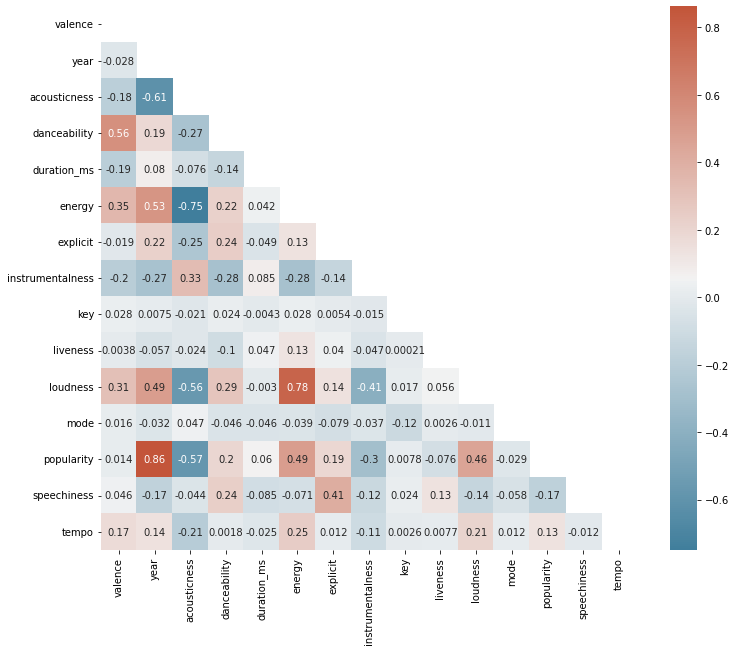

In [ ]:
corr = data.corr()
f, ax = plt.subplots(figsize=(12, 10))
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, annot=True, mask = mask, cmap=cmap)

אם נסתכל על עמודת השנה שבו יצא השיר, ניתן לראות כי הוא בעל קורלציה חיובית גבוהה עם עמודת הפופולאריות - כלומר, ככל ששיר עדכני יותר, כך סיכויו להיות פופולארי עולה.
כמו כן, ישנה קורלציה חיובית די גבוהה בין השנה לבין משתנה האנרגיה - כך שכנראה שבשנים האחרונות השירים יותר ויותר אנרגטיים. באופן דומה, ישנו קשר שלילי בין השנה לאקוסטיות, כך שככל שהשיר עדכני יותר כך הוא מתאפיין באקוסטיות נמוכה יותר. באופן לא מפתיע, וזאת בשל הקורלציה החיובית הגבוהה בין השנה לפופולאריות, גם בין עמודת הפופולאריות לבין עמודת האקוסטיות קיימת קורלציה שלילית די גבוהה - כך ששירים פופולאריים יותר מתאפיינים באקוסטיות נמוכה יותר.

כעת נבחן את הקשר בין ז'אנרים מוזיקאליים שונים לבין משתנה הפופולריות, על מנת לנסות ולהבין אילו שירים נוטים להיות יותר פופולרים:

In [ ]:
data_with_gener[['genre','popularity']].groupby(['genre']).mean()

,popularity
genre,
A Capella,9.302521
Alternative,50.213430
Anime,24.258729
Blues,34.742879
Children's Music,36.202426
Classical,29.282195
Comedy,21.342630
Country,46.100416
Dance,57.275256


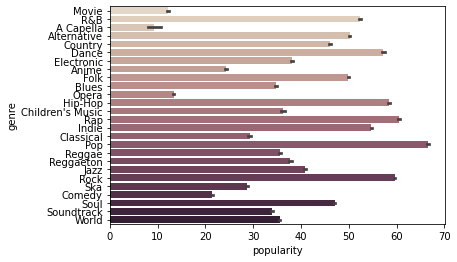

In [ ]:
ax = sns.barplot(x="popularity", y="genre", data=data_with_gener, palette="ch:.25")

כפי שניתן לראות, שירים המשתייכים לז'אנר הפופ נוטים להיות פופולרים יותר. כמו כן, שירי ראפ, רוק, היפ-הופ ודאנס נוטים להיות פופולרים גם כן.
להלן 10 השירים הפופולריים ביותר בקובץ הנתונים:

In [ ]:
data_with_gener.nlargest(n=10, columns=['popularity'])

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,popular
9027,Dance,Ariana Grande,7 rings,14msK75pk3pA33pzPVNtBF,100,0.5780,0.725,178640,0.321,0.000000,C#,0.0884,-10.744,Minor,0.3230,70.142,04-אפר,0.319,True
107804,Pop,Ariana Grande,7 rings,14msK75pk3pA33pzPVNtBF,100,0.5780,0.725,178640,0.321,0.000000,C#,0.0884,-10.744,Minor,0.3230,70.142,04-אפר,0.319,True
9026,Dance,Ariana Grande,"break up with your girlfriend, i'm bored",4kV4N9D1iKVxx1KLvtTpjS,99,0.0421,0.726,190440,0.554,0.000000,F,0.1060,-5.290,Minor,0.0917,169.999,04-אפר,0.335,True
86951,Rap,Post Malone,Wow.,6MWtB6iiXyIwun0YzU6DFP,99,0.1630,0.833,149520,0.539,0.000002,B,0.1010,-7.399,Minor,0.1780,99.947,04-אפר,0.385,True
107802,Pop,Ariana Grande,"break up with your girlfriend, i'm bored",4kV4N9D1iKVxx1KLvtTpjS,99,0.0421,0.726,190440,0.554,0.000000,F,0.1060,-5.290,Minor,0.0917,169.999,04-אפר,0.335,True
107803,Pop,Post Malone,Wow.,6MWtB6iiXyIwun0YzU6DFP,99,0.1630,0.833,149520,0.539,0.000002,B,0.1010,-7.399,Minor,0.1780,99.947,04-אפר,0.385,True
66643,Hip-Hop,Daddy Yankee,Con Calma,5w9c2J52mkdntKOmRLeM2m,98,0.1100,0.737,193227,0.860,0.000002,G#,0.0574,-2.652,Minor,0.0593,93.989,04-אפר,0.656,True
9028,Dance,Halsey,Without Me,5p7ujcrUXASCNwRaWNHR1C,97,0.2970,0.752,201661,0.488,0.000009,F#,0.0936,-7.050,Major,0.0705,136.041,04-אפר,0.533,True
9037,Dance,Ava Max,Sweet but Psycho,25sgk305KZfyuqVBQIahim,97,0.0691,0.719,187436,0.704,0.000000,C#,0.1660,-4.724,Major,0.0476,133.002,04-אפר,0.628,True
86953,Rap,Post Malone,Sunflower - Spider-Man: Into the Spider-Verse,3KkXRkHbMCARz0aVfEt68P,97,0.5560,0.760,158040,0.479,0.000000,D,0.0703,-5.574,Major,0.0466,89.911,04-אפר,0.913,True


כל עשרת השירים משתייכים לז'אנרים המובילים.

בשלב הבא נסווג כל שיר בהתאם לציון הפופולריות שקיבל, כך ששירים שדורגו עם ציון של 60 ומעלה ייחשבו כפופולרים, בעוד ששירים שקיבלו ציון נמוך מכך ייחשבו כשירים שאינם פופולרים.

In [ ]:
data['popular'] = np.where(data['popularity']>=60, True, False)
data.drop(["id","release_date"], axis=1, inplace=True)
data.head(2)

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,name,popularity,speechiness,tempo,popular
0,0.0594,1921,0.982,"['Sergei Rachmaninoff', 'James Levine', 'Berli...",0.279,831667,0.211,0,0.878,10,0.665,-20.096,1,"Piano Concerto No. 3 in D Minor, Op. 30: III. ...",4,0.0366,80.954,False
1,0.9630,1921,0.732,['Dennis Day'],0.819,180533,0.341,0,0.000,7,0.160,-12.441,1,Clancy Lowered the Boom,5,0.4150,60.936,False


In [ ]:
data.popular.value_counts()

False    153101
True      17552
Name: popular, dtype: int64

In [ ]:
data.popular.mean()

0.10285198619420696

בסך הכל, כ-10% מהשירים קיבלו ציון 60 ומעלה בפרמטר הפופולריות, ומסווגים כשירים פופולרים.

כעת נבדוק את אחוז השירים הפופולריים, לפי העשור שבהם יצאו:

Text(0, 0.5, 'Percent of popular songs')

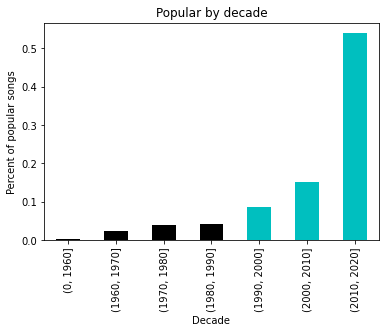

In [ ]:
fig = data["popular"].groupby(pd.cut(data["year"],[0, 1960, 1970, 1980, 1990, 2000, 2010, 2020])).mean().plot(kind='bar', color=list("kkkkccc"))
plt.title("Popular by decade")
plt.xlabel("Decade")
plt.ylabel("Percent of popular songs")

כפי שניתן לראות, הרוב המכריע של השירים הפופולריים שנמצאים בקובץ יצאו בעשור האחרון. שירים מועטים בלבד שיצאו לפני שנות ה-90 סווגו כפופולריים

In [ ]:
fig = px.line(year_data, x='year', y='popularity')
fig.show()

כעת נבחן את משתנה הפופולריות לפי תכונת האקוסטיות:

Text(0, 0.5, 'Percent of popular songs')

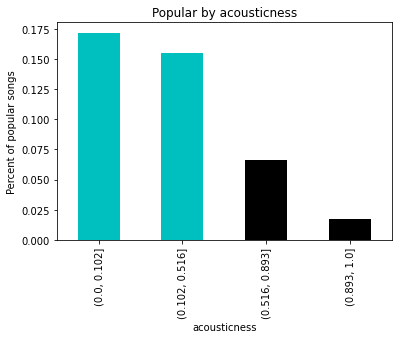

In [ ]:
fig = data["popular"].groupby(pd.cut(data["acousticness"],[0, 0.102, 0.516, 0.893, 1])).mean().plot(kind='bar', color=list("cckk"))
plt.title("Popular by acousticness")
plt.xlabel("acousticness")
plt.ylabel("Percent of popular songs")

כפי שניתן היה להניח בעקבות התוצאות שראינו בניתוח באמצעות מקדם המתאם של פירסון, שירים בעלי אקוסטיות נמוכה נוטים להיות פופולריים יותר.

נתבונן כעת על פרמטרים נוספים של סאונד, וכיצד הם השתנו לאורך השנים:

In [ ]:
sound_features = ['valence', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'speechiness']
fig = px.line(year_data, x='year', y=sound_features)
fig.show()

כצפוי, עם השנים יצאו פחות שירים בעלי ערך גבוה של אקוסטיות ; כמו כן, חלה עליה קלה בשירים המתאפיינים באנרגטיות גבוהה.

In [ ]:
fig = px.line(year_data, x='year', y='loudness')
fig.show()

באופן דומה, עם הזמן יצאו יותר שירים רועשים.

In [ ]:
fig = px.line(year_data, x='year', y='tempo')
fig.show()

החל משנות ה-50 ועד לשנות ה-80 הייתה עלייה מתמדת בקצביות השירים. משנות ה-80 ועד היום רמת הקיצביות נותרה יחסית יציבה.

# Ziv start

Now, when we have a better understanding of the data and how it works we can 

Creating a data for our model with all of the relevant features (we might change this during the process). 

Removing very old songs that will not be relevant for our model due to the extreme change of culture in music. Furthermore, very old songs get very low popularity because only few people hear these songs on spotify. We will take all songs from 1970 - 2020 for our model.
Also, we wish to fit a fine and relevant model that fits current data from recent years (things change). 


In [ ]:
data = data1.sort_values(by=['year'])

In [ ]:
model_features = ['popularity', 'year', 'valence', 'explicit', 'acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 'speechiness', 'tempo']
model_data = data[model_features]
model_data = model_data.iloc[70000:].reset_index().iloc[:,1:]
model_data.head(5)

,popularity,year,valence,explicit,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo
0,34,1970,0.457,0,0.635,0.355,217267,0.502,0.000020,2,0.0988,-9.814,1,0.0457,81.262
1,29,1970,0.376,0,0.511,0.395,198787,0.468,0.000000,0,0.0827,-8.723,1,0.0294,167.316
2,36,1970,0.278,0,0.836,0.222,200253,0.316,0.000067,5,0.1120,-13.205,1,0.0312,153.572
3,35,1970,0.419,0,0.414,0.494,227200,0.331,0.000052,0,0.0849,-11.276,1,0.0346,140.731
4,28,1970,0.927,0,0.951,0.796,168400,0.457,0.808000,0,0.1470,-8.422,1,0.0365,105.469


Removing 0 values so we could have the option to take some mathematical actions without dealing with "0" values and it is possible that "0" values are mistakes which would damage our model predictions.

In [ ]:
model_data = model_data[model_data.popularity > 0]

In [ ]:
model_data.shape

(99997, 15)

Checking the distribution of the popularities so we can now which threshold we should use.

In [ ]:
model_data.popularity.describe(percentiles=[0.25,0.85])

count    99997.000000
mean        45.506805
std         13.755569
min          1.000000
25%         35.000000
50%         45.000000
85%         61.000000
max        100.000000
Name: popularity, dtype: float64

In [ ]:
X = model_data.iloc[:,1:]
X.head(5)

,year,valence,explicit,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo
0,1970,0.457,0,0.635,0.355,217267,0.502,0.000020,2,0.0988,-9.814,1,0.0457,81.262
1,1970,0.376,0,0.511,0.395,198787,0.468,0.000000,0,0.0827,-8.723,1,0.0294,167.316
2,1970,0.278,0,0.836,0.222,200253,0.316,0.000067,5,0.1120,-13.205,1,0.0312,153.572
3,1970,0.419,0,0.414,0.494,227200,0.331,0.000052,0,0.0849,-11.276,1,0.0346,140.731
4,1970,0.927,0,0.951,0.796,168400,0.457,0.808000,0,0.1470,-8.422,1,0.0365,105.469


Scaling an object means multiplying every linear dimension of it by the same factor. Thus you change the size of the object, but not its shape.

In [ ]:
from sklearn import preprocessing
#Scaling our X matrix 
scaled_X = preprocessing.scale(X)
scaled_X = pd.DataFrame(X)
scaled_X.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,-1.707277,-0.305398,-0.366951,1.057210,-1.192678,-0.250654,-0.400472,-0.405345,-0.912164,-0.566834,-0.067638,0.654465,-0.361231,-1.308163
1,-1.707277,-0.617013,-0.366951,0.658212,-0.964527,-0.431158,-0.540277,-0.405426,-1.476085,-0.656929,0.151246,0.654465,-0.537546,1.553741
2,-1.707277,-0.994029,-0.366951,1.703971,-1.951281,-0.416839,-1.165290,-0.405156,-0.066282,-0.492966,-0.747966,0.654465,-0.518075,1.096656
3,-1.707277,-0.451588,-0.366951,0.346093,-0.399853,-0.153633,-1.103611,-0.405213,-1.476085,-0.644618,-0.360955,0.654465,-0.481298,0.669602
4,-1.707277,1.502738,-0.366951,2.074009,1.322690,-0.727964,-0.585508,2.871963,-1.476085,-0.297106,0.211635,0.654465,-0.460746,-0.503109


We can classify our explained variable to two categories - popular & not popular. We would use the top 15% as an indication of popular song, meaning that songs with values higher than 60 will be 1 and under 60 will be 0. 

Then we can use several different relevant models as baselines and compare to neural network model. 

In [ ]:
Y = np.where(model_data.popularity > 60, 1, 0)
Y.shape

Dividing our data to train and test as part of the evaluation of our data mining models. 

Keeping the same distribution of "popularity" in both subsets as in the original dataset using stratify. 

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(scaled_X, Y, test_size=0.2, random_state=42, stratify = Y)
print('Training set size: {0:d}\nTest set size: {1:d}'.format(len(x_train),len(x_test)))

Training set size: 79997
Test set size: 20000


Logistic Regression

In [ ]:
import sklearn.metrics as metrics
from sklearn.linear_model import LogisticRegression

model_reg = LogisticRegression(random_state=0).fit(x_train, y_train)

probs = model_reg.predict_proba(x_test)
preds = probs[:,1]

log_pred = np.where(preds > 0.5 , 1, 0) #We can also use - np.percentile(preds, 85)

In [ ]:
from sklearn.metrics import confusion_matrix,precision_score,recall_score,f1_score,roc_auc_score, accuracy_score

#Creating a useful function that prints out several indicative results of a model. 
def model_results(y,y_hat):
  cm=confusion_matrix(y,y_hat)
  pre=precision_score(y,y_hat)
  rec=recall_score(y,y_hat)
  f1=f1_score(y,y_hat)
  auc=roc_auc_score(y,y_hat)
  accuracy = accuracy_score(y, y_hat)

  print(f'Precision score: {pre:3.3f}')
  print(f'Recall score: {rec:3.3f}')
  print(f'F1 score: {f1:3.3f}')
  # print(f'AUC score: {auc:3.3f}')
  print(f'Accuracy: {accuracy:3.3f}')
  print('Confusion matrix:')
  print(cm)
  return cm

Precision score: 0.780
Recall score: 0.373
F1 score: 0.505
Accuracy: 0.887
Confusion matrix:
[[16599   324]
 [ 1929  1148]]


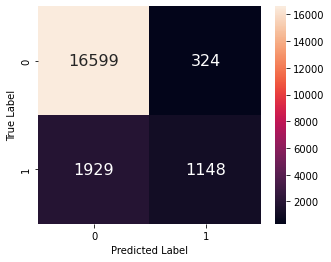

In [ ]:
cm = model_results(y_test, log_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True,fmt="d",annot_kws={"size": 16}) # font size
plt.xlabel('Predicted Label'); plt.ylabel('True Label');

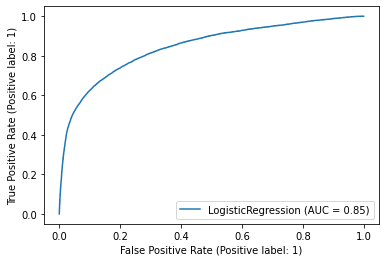

In [ ]:
from sklearn.metrics import roc_curve,plot_roc_curve, balanced_accuracy_score

plot_roc_curve(model_reg,x_train,y_train)

KNN

In [ ]:
knn = KNeighborsClassifier()
knn.fit(x_train, y_train)
knn_predict = knn.predict(x_test)
knn.score(x_test,y_test)

0.8665

A pipe is a method to pass information from one process to another process.

Grid-searching is the process of scanning the data to configure optimal parameters for a given model. Depending on the type of model utilized, certain parameters are necessary.



In [ ]:
pipe=make_pipeline(StandardScaler(),
                  KNeighborsClassifier())

pipe.fit(x_train,y_train)
acc=np.sum(pipe.predict(x_test)==y_test)/y_test.shape[0]
print("The accuracy for th KNN model is:",'%.2f%%'%acc)

The accuracy for th KNN model is: 0.87%


In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {'kneighborsclassifier__p': [1,2],
              'kneighborsclassifier__n_neighbors': [1, 3, 5, 7, 9]}

gs = GridSearchCV(estimator=pipe,
                  param_grid=param_grid,
                  refit=True,#default
                  cv=5,#k-fold cross validation, strtified, accuracy
                  n_jobs=-1)

gs.fit(x_train, y_train)

print('Best Accuracy: %.2f%%' % (gs.best_score_*100))#available after fitting
print('Best Params:', gs.best_params_)#get the parameter combination

Best Accuracy: 87.55%
Best Params: {'kneighborsclassifier__n_neighbors': 9, 'kneighborsclassifier__p': 1}


In [ ]:
knn_pred = gs.predict(x_test)

Precision score: 0.668
Recall score: 0.384
F1 score: 0.488
Accuracy: 0.876
Confusion matrix:
[[16336   587]
 [ 1896  1181]]


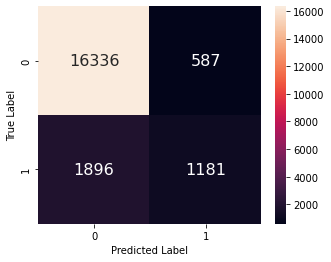

In [ ]:
cm = model_results(y_test, knn_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True,fmt="d",annot_kws={"size": 16}) # font size
plt.xlabel('Predicted Label'); plt.ylabel('True Label');

Decision Tree Classifier

In [ ]:
dt = DecisionTreeClassifier(random_state=123, max_depth=15)
dt.fit(x_train,y_train)
dt_pred = dt.predict(x_test)

Precision score: 0.616
Recall score: 0.440
F1 score: 0.513
Accuracy: 0.872
Confusion matrix:
[[16081   842]
 [ 1724  1353]]


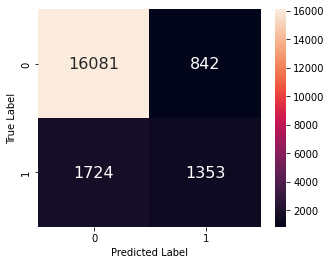

In [ ]:
cm = model_results(y_test, dt_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True,fmt="d",annot_kws={"size": 16}) # font size
plt.xlabel('Predicted Label'); plt.ylabel('True Label');

Now, we aill do grid search to find the best parameters for the model

In [ ]:
from sklearn.tree import DecisionTreeClassifier

param_grid = {'max_depth': [1, 2, 3, 4, 5, 6, None],
               'criterion': ['gini', 'entropy']}


gs = GridSearchCV(estimator=DecisionTreeClassifier(random_state=123),
                  param_grid=param_grid,
                  refit=True,#default
                  cv=10,#k-fold cross validation
                  n_jobs=-1)

gs.fit(x_train, y_train)

print('Best Accuracy: %.2f%%' % (gs.best_score_*100))
print('Best Params:', gs.best_params_)

acc=np.sum(gs.best_estimator_.predict(x_test)==y_test)/y_test.shape[0]
print('best estimator score is %.2f%%'%gs.best_estimator_.score(x_test,y_test))

Best Accuracy: 89.70%
Best Params: {'criterion': 'gini', 'max_depth': 5}
best estimator score is 0.89%


In [ ]:
DT_pred = gs.predict(x_test)

Precision score: 0.778
Recall score: 0.426
F1 score: 0.550
Accuracy: 0.893
Confusion matrix:
[[16549   374]
 [ 1767  1310]]


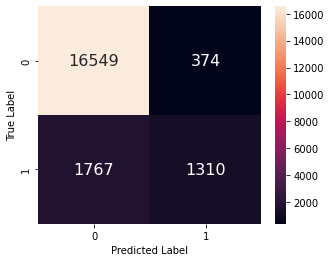

In [ ]:
cm = model_results(y_test, DT_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True,fmt="d",annot_kws={"size": 16}) # font size
plt.xlabel('Predicted Label'); plt.ylabel('True Label');

Random Forest

Random forest is a Supervised Machine Learning Algorithm that is used widely in Classification and Regression problems. It builds **decision trees** on different samples and takes their majority vote for classification and average in case of regression.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

clf1=RandomForestClassifier(random_state=123,n_jobs=-1)
clf1.fit(x_train,y_train)
rf_pred = clf1.predict(x_test)

Precision score: 0.751
Recall score: 0.457
F1 score: 0.568
Accuracy: 0.893
Confusion matrix:
[[16457   466]
 [ 1670  1407]]


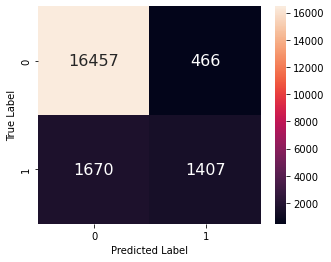

In [ ]:
cm = model_results(y_test, rf_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True,fmt="d",annot_kws={"size": 16}) # font size
plt.xlabel('Predicted Label'); plt.ylabel('True Label');

#Neural Networks

Activation functions:


*   *Sigmoid* : $\frac{1}{1+e^{-z}}$

*   *reLU* : $max(0,z)$

*   *Softmax* : $\frac{e^{z_i}}{\sum_{j=1}^{K} e^{z_j}}$



In [ ]:
train_nn = pd.get_dummies(y_train).values
test_nn = pd.get_dummies(y_test).values

train_nn.shape, test_nn.shape 

((79997, 2), (20000, 2))

In [ ]:
# Define the model layout:
model = Sequential()
model.add(Dense(32, input_dim=14, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(2, activation='softmax'))

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history = model.fit(x_train, train_nn, validation_data=None, epochs=10, verbose=2)

Epoch 1/10
2500/2500 - 5s - loss: 0.3185 - accuracy: 0.8775 - 5s/epoch - 2ms/step
Epoch 2/10
2500/2500 - 4s - loss: 0.2926 - accuracy: 0.8920 - 4s/epoch - 1ms/step
Epoch 3/10
2500/2500 - 5s - loss: 0.2898 - accuracy: 0.8939 - 5s/epoch - 2ms/step
Epoch 4/10
2500/2500 - 5s - loss: 0.2882 - accuracy: 0.8949 - 5s/epoch - 2ms/step
Epoch 5/10
2500/2500 - 5s - loss: 0.2872 - accuracy: 0.8950 - 5s/epoch - 2ms/step
Epoch 6/10
2500/2500 - 4s - loss: 0.2864 - accuracy: 0.8959 - 4s/epoch - 1ms/step
Epoch 7/10
2500/2500 - 4s - loss: 0.2861 - accuracy: 0.8956 - 4s/epoch - 1ms/step
Epoch 8/10
2500/2500 - 4s - loss: 0.2857 - accuracy: 0.8952 - 4s/epoch - 1ms/step
Epoch 9/10
2500/2500 - 4s - loss: 0.2849 - accuracy: 0.8964 - 4s/epoch - 1ms/step
Epoch 10/10
2500/2500 - 4s - loss: 0.2843 - accuracy: 0.8965 - 4s/epoch - 1ms/step


In [ ]:
# Test the model agains train set: 
train_loss, train_acc = model.evaluate(x_train, train_nn, verbose=2)

print('\nTrain accuracy:', round(train_acc,4))

2500/2500 - 3s - loss: 0.2846 - accuracy: 0.8966 - 3s/epoch - 1ms/step

Train accuracy: 0.8966


In [ ]:
# Test the model agains test set: 
test_loss, test_acc = model.evaluate(x_test, test_nn, verbose=2)

print('\nTest accuracy:', round(test_acc,4))

625/625 - 1s - loss: 0.2920 - accuracy: 0.8935 - 1s/epoch - 2ms/step

Test accuracy: 0.8935


In [ ]:
NN_pred = model.predict(x_test)

In [ ]:
nn_pred = [int(np.where(x[0] < 0.5, 1, 0)) for x in NN_pred] 

Precision score: 0.750
Recall score: 0.462
F1 score: 0.572
Accuracy: 0.893
Confusion matrix:
[[16448   475]
 [ 1655  1422]]


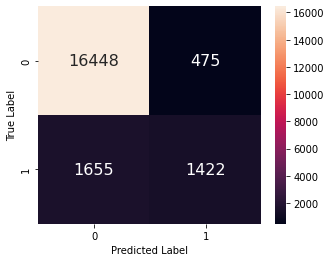

In [ ]:
cm = model_results(y_test, nn_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True,fmt="d",annot_kws={"size": 16}) # font size
plt.xlabel('Predicted Label'); plt.ylabel('True Label');

So, we got a pretty good model. Now we want to try to improve our model. We can try adding a hidden layer and change the number of nods inside the hidden layers. Also we can try to use the 'sigmoid' activation function because of our type of data (our Y is {0,1}).
Moreover, we can try 50 epochs and see if our model improves. 

In [ ]:
# Define the model layout:
model2 = Sequential()
model2.add(Dense(200, input_dim=14, activation='relu'))
model2.add(Dense(120, activation='relu'))
model2.add(Dense(60, activation='relu'))
model2.add(Dense(4, activation='relu'))
model2.add(Dense(2, activation='sigmoid'))

In [ ]:
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history = model2.fit(x_train, train_nn, validation_data=None, epochs=50, verbose=2)

Epoch 1/50
2500/2500 - 8s - loss: 0.3063 - accuracy: 0.8841 - 8s/epoch - 3ms/step
Epoch 2/50
2500/2500 - 5s - loss: 0.2927 - accuracy: 0.8919 - 5s/epoch - 2ms/step
Epoch 3/50
2500/2500 - 5s - loss: 0.2896 - accuracy: 0.8936 - 5s/epoch - 2ms/step
Epoch 4/50
2500/2500 - 5s - loss: 0.2886 - accuracy: 0.8940 - 5s/epoch - 2ms/step
Epoch 5/50
2500/2500 - 5s - loss: 0.2866 - accuracy: 0.8949 - 5s/epoch - 2ms/step
Epoch 6/50
2500/2500 - 5s - loss: 0.2859 - accuracy: 0.8957 - 5s/epoch - 2ms/step
Epoch 7/50
2500/2500 - 5s - loss: 0.2846 - accuracy: 0.8954 - 5s/epoch - 2ms/step
Epoch 8/50
2500/2500 - 5s - loss: 0.2840 - accuracy: 0.8960 - 5s/epoch - 2ms/step
Epoch 9/50
2500/2500 - 5s - loss: 0.2826 - accuracy: 0.8969 - 5s/epoch - 2ms/step
Epoch 10/50
2500/2500 - 5s - loss: 0.2820 - accuracy: 0.8969 - 5s/epoch - 2ms/step
Epoch 11/50
2500/2500 - 5s - loss: 0.2812 - accuracy: 0.8971 - 5s/epoch - 2ms/step
Epoch 12/50
2500/2500 - 5s - loss: 0.2800 - accuracy: 0.8971 - 5s/epoch - 2ms/step
Epoch 13/50
2

In [ ]:
# Test the model agains train set: 
train_loss, train_acc = model2.evaluate(x_train, train_nn, verbose=2)

print('\nTrain accuracy:', round(train_acc,4))

2500/2500 - 3s - loss: 0.2177 - accuracy: 0.9163 - 3s/epoch - 1ms/step

Train accuracy: 0.9163


In [ ]:
# Test the model against test set: 
test_loss, test_acc = model2.evaluate(x_test, test_nn, verbose=2)

print('\nTest accuracy:', round(test_acc,4))

625/625 - 1s - loss: 0.3811 - accuracy: 0.8868 - 1s/epoch - 2ms/step

Test accuracy: 0.8868


In [ ]:
NN_pred2 = model2.predict(x_test)

In [ ]:
nn_pred2 = [int(np.where(x[0] < 0.5, 1, 0)) for x in NN_pred2] 

Precision score: 0.698
Recall score: 0.475
F1 score: 0.565
Accuracy: 0.888
Confusion matrix:
[[16292   631]
 [ 1616  1461]]


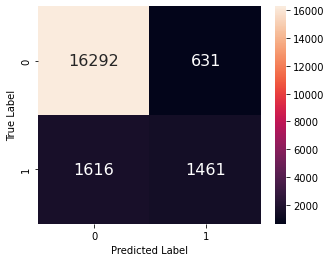

In [ ]:
cm = model_results(y_test, nn_pred2)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True,fmt="d",annot_kws={"size": 16}) # font size
plt.xlabel('Predicted Label'); plt.ylabel('True Label');

As we can see, the model against train set has improved a lot. However, the model against the test set is worse, this indicates overfitting. 
So, we should consider going back to the first model and keep trying to improve it.

For example, we would try to add Dropout layers to see if it improves the model.

Note that, Embedding and LSTM will (probably) not be useful to our kind of data because Long Short-Term Memory (LSTM) networks are a type of recurrent neural network capable of learning order dependence in **sequence prediction problems** such as machine translation, speech recognition (which is not the case here).

In [ ]:
from keras.layers import Dropout

# Define the model layout:
model3 = Sequential()
model3.add(Dense(64, input_dim=14, activation='relu'))
model3.add(Dropout(0.3))
model3.add(Dense(32, activation='relu'))
model3.add(Dropout(0.3))
model3.add(Dense(16, activation='relu'))
model3.add(Dropout(0.3))
model3.add(Dense(2, activation='softmax'))

In [ ]:
model3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history = model3.fit(x_train, train_nn, validation_data=None, epochs=10, verbose=2)

Epoch 1/10
2500/2500 - 5s - loss: 0.3493 - accuracy: 0.8610 - 5s/epoch - 2ms/step
Epoch 2/10
2500/2500 - 4s - loss: 0.3149 - accuracy: 0.8793 - 4s/epoch - 2ms/step
Epoch 3/10
2500/2500 - 4s - loss: 0.3074 - accuracy: 0.8841 - 4s/epoch - 2ms/step
Epoch 4/10
2500/2500 - 4s - loss: 0.3042 - accuracy: 0.8868 - 4s/epoch - 2ms/step
Epoch 5/10
2500/2500 - 4s - loss: 0.3018 - accuracy: 0.8889 - 4s/epoch - 2ms/step
Epoch 6/10
2500/2500 - 4s - loss: 0.3011 - accuracy: 0.8886 - 4s/epoch - 2ms/step
Epoch 7/10
2500/2500 - 4s - loss: 0.2997 - accuracy: 0.8896 - 4s/epoch - 2ms/step
Epoch 8/10
2500/2500 - 4s - loss: 0.2987 - accuracy: 0.8901 - 4s/epoch - 2ms/step
Epoch 9/10
2500/2500 - 4s - loss: 0.2991 - accuracy: 0.8899 - 4s/epoch - 2ms/step
Epoch 10/10
2500/2500 - 4s - loss: 0.2979 - accuracy: 0.8913 - 4s/epoch - 2ms/step


In [ ]:
# Test the model agains train set: 
train_loss, train_acc = model3.evaluate(x_train, train_nn, verbose=2)

print('\nTrain accuracy:', round(train_acc,4))

2500/2500 - 4s - loss: 0.2852 - accuracy: 0.8974 - 4s/epoch - 1ms/step

Train accuracy: 0.8974


In [ ]:
# Test the model against test set: 
test_loss, test_acc = model3.evaluate(x_test, test_nn, verbose=2)

print('\nTest accuracy:', round(test_acc,4))

625/625 - 1s - loss: 0.2905 - accuracy: 0.8948 - 1s/epoch - 2ms/step

Test accuracy: 0.8948


In [ ]:
NN_pred3 = model3.predict(x_test)
nn_pred3 = [int(np.where(x[0] < 0.5, 1, 0)) for x in NN_pred3] 

Precision score: 0.749
Recall score: 0.475
F1 score: 0.582
Accuracy: 0.895
Confusion matrix:
[[16433   490]
 [ 1614  1463]]


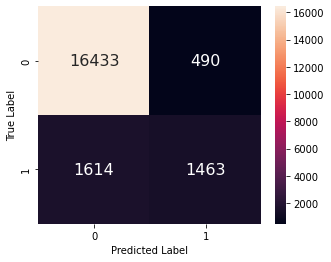

In [ ]:
cm = model_results(y_test, nn_pred3)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True,fmt="d",annot_kws={"size": 16}) # font size
plt.xlabel('Predicted Label'); plt.ylabel('True Label');

In conclusion, thanks to the wide range of options that we can alter and "play" with in the Neural Networks model we should choose it as the best model to predict the popularity of a song. 

Note that, we got a good model but you can always improve a Neural Networks model. 